In [1]:
from phi.torch.flow import *
import matplotlib.pyplot as plt

from src.eigenfluid import Eigenfluid
from src.shapes import *

# Helper functions for visualization
from src.visu import *

import time

In [3]:
# Number of basis fields
N = 4**2
# Domain sizes
DOMAIN = Box(x=math.PI, y=math.PI)
SAMPLING_SIZE = 32

In [6]:
start_time = time.time()
eigenfluid = Eigenfluid(N, DOMAIN, SAMPLING_SIZE)
end_time = time.time()
print("Eigenfluid initialized in {} seconds".format(end_time-start_time))

Eigenfluid initialized in 9.24764895439148 seconds


# Optimize Initial Velocity Field for Target Positions

In [7]:
STEPS = 32
DT    = 0.2
VISCOSITY = 0.0

def loss_function(w, p, p_target):
    eigenfluid.w = w
    trajectory_p = [p]
    for i in range(STEPS-1):
        # Step velocity
        eigenfluid.w = eigenfluid.step_w_euler(eigenfluid.w, DT, viscosity=VISCOSITY)
        # Get velocities at new positions
        p_velocities = eigenfluid.get_phi_at(p)
        # Midpoint
        p_velocities = eigenfluid.get_phi_at(p + p_velocities*DT/2)
        # Euler step for points
        p += p_velocities * DT
        trajectory_p.append(p)
    loss = field.l2_loss(p - p_target)
    return (loss, trajectory_p)

gradient_function = math.gradient(loss_function)

Initial Loss: 3.9999554


<Figure size 300x300 with 1 Axes>

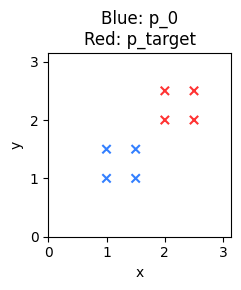

In [20]:
# Initialize start and target points
p_sample = get_sample_points(N=4, method="grid")

f_0 = get_f_rectangle(pos=(1,1))
f_target = get_f_rectangle(pos=(2,2))

p_0, p_target = f_0(p_sample), f_target(p_sample)

# Initialize w to some value for optimization (random or 0)
w_init = math.zeros_like(eigenfluid.w) + 0.001
#w_init = math.random_normal(eigenfluid.w.shape)

# first gradient
(loss, trajectory_p), grad = gradient_function(w_init, p_0, p_target)
print("Initial Loss: {}".format(loss))

# Plot optimization setup
vis.plot({"Blue: p_0\nRed: p_target": vis.overlay(
    PointCloud(p_0, bounds=DOMAIN),
    PointCloud(p_target, bounds=DOMAIN, color="red")
)}, size=(3,3))

In [21]:
LR = 10**-2

w_optim = w_init
grads = []
for optim_step in range(50):
    (loss, trajectory_p), grad = gradient_function(w_optim, p_0, p_target)
    if optim_step%5 == 0 or optim_step < 5:
        print("Optimization step %d, loss: %f" % (optim_step, loss))
    if optim_step == 51: 
        LR /= 2
        print("LR = {}".format(LR))
        
    grads.append( grad[0] )
    
    w_optim = w_optim - LR * grads[-1]

Optimization step 0, loss: 3.999955
Optimization step 1, loss: 1.202690
Optimization step 2, loss: 0.523805
Optimization step 3, loss: 0.315125
Optimization step 4, loss: 0.201088
Optimization step 5, loss: 0.131135
Optimization step 10, loss: 0.019863
Optimization step 15, loss: 0.005274
Optimization step 20, loss: 0.002546
Optimization step 25, loss: 0.001713


KeyboardInterrupt: 

### Plot Results of Optimization

In [22]:
trajectory_p = math.stack(trajectory_p, batch('time'))
target_time = math.stack([p_target]*STEPS, batch('time'))

#trajectory_v = math.stack(trajectory_v, batch('time'))
#trajectory_curl_ref = math.stack(trajectory_curl, batch('time'))

#velocity_field = math.stack([eigenfluid.reconstruct_velocity()]*STEPS, batch('time'))

vis.plot(vis.overlay(PointCloud(trajectory_p, bounds=DOMAIN),
                     PointCloud(target_time, bounds=DOMAIN, color="red")
                    ),
        animate='time',
        same_scale=False,
        size=(4,4)
)

<Figure size 640x480 with 0 Axes>

# Compare Results with Advection of Smoke Marker

In [23]:
def init_smoke():
    smoke = CenteredGrid(
        Box['x,y', 1:1.5, 1:1.5], 
        extrapolation.BOUNDARY, 
        x=100, y=100, 
        bounds=DOMAIN
    )
    return smoke

In [24]:
eigenfluid.w = w_optim

velocity = eigenfluid.reconstruct_velocity()
smoke = init_smoke()

vel_traj = [velocity]
w_traj = [eigenfluid.w]
smoke_traj = [smoke]

start_time = time.time()
for i in range(STEPS-1):
    # Simulate
    eigenfluid.w = eigenfluid.step_w_euler(eigenfluid.w, DT, viscosity=VISCOSITY)
    velocity = eigenfluid.reconstruct_velocity()
    smoke = advect.mac_cormack(smoke, velocity, dt=DT)
    # Save trajectory
    vel_traj.append(velocity)
    w_traj.append(eigenfluid.w)
    smoke_traj.append(smoke)
end_time = time.time()
print("Simulation finished in {} seconds".format(end_time-start_time))

Simulation finished in 5.989207983016968 seconds


In [25]:
trajectory_v = math.stack(vel_traj, batch('time'))
#trajectory_curl = math.stack(trajectory_curl, batch('time'))
trajectory_smoke = math.stack(smoke_traj, batch('time'))
trajectory_w = math.stack(list(map(get_w_point_cloud, [w*10 for w in w_traj])), batch('time'))

vis.plot({
    "Blue points: simulated points\nRed points: target points\nOverlayed with independent\nhigh-res smoke sim.": 
    vis.overlay(
        trajectory_smoke,
        PointCloud(trajectory_p, bounds=DOMAIN),
        PointCloud(target_time, bounds=DOMAIN, color="red"),        
    ), 
    "Velocity Field": trajectory_v,
    "w basis coefficients \n(*10 for visualization)": trajectory_w
}, animate='time', same_scale=False)

<Figure size 640x480 with 0 Axes>